# Машинное обучение, DS-поток, осень 2022
# Задание 3.5. Решающие деревья

## Задача 1

Докажите, что критерий Джини равен вероятности ошибки случайного классификатора, который выдаёт предсказания с вероятностями пропорционально доле классов в выборке. 

## Задача 2

Пусть $X = (x_1, ..., x_n)$ &mdash; выборка объектов и $Y = (Y_1, ..., Y_n)$ &mdash; соответствующие значения вещественного отклика. Критерий информативности для набора объектов вычисляется на основе того, насколько хорошо их отклик предсказывается константой:

$$
H(X) = \min_{c \in Y} \dfrac{1}{n} \sum_{i=1}^n L(Y_i, c),
$$

где $L(y, c)$ &mdash; некоторая функция потерь. Соответственно, чтобы получить вид критерия при конкретной функции потерь, необходимо аналитически найти оптимальное значение константы и подставить его в формулу для $H(X)$.

Выведите критерии информативности для следующих функций потерь:
1. $L(y, c) = (y-c)^2$;
2. $L(y, c) = |y-c|$.

Найдите также оптимальное предсказание в листьях дерева.

## Задача 3

В случае задачи классификации рассматривается вероятностное предсказание, и критерий информативности имеет вид
$$H(X) = \min_{\stackrel{p_1, ..., p_K \in [0, 1]}{p_1+...+p_K=1}} \dfrac{1}{n} \sum_{i=1}^n L\left(Y_i, \{p_k\}\right).$$
Выведите и упростите критерии информативности, найдите оптимальные оценки вероятностей в листах для следующих функций потерь:
* $L(y, \{p_k\}) = \sum_{k=1}^K \left(p_k-I\{y=k\}\right)^2$;
* $L(y, \{p_k\}) = -\sum_{k=1}^K I\{ y=k\}\log p_k$.

*Задачи 1-3 - в отдельном файле*

## Задача 4

In [25]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_wine
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV



import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(font_scale=1.6)
plt.rcParams['axes.facecolor'] = 'lightgrey'

Вспомним, как именно происходит построение решающего дерева. Для построения дерева в каждой нелистовой вершине происходит разбиение подвыборки на две части по некоторому признаку $x_j$. Этот признак и порог $t$, по которому будет происходить разбиение, мы хотим брать не произвольно, а основываясь на соображениях оптимальности.  Для этого нам необходимо знать некоторый фукционал качества, который будем оптимизировать при построении разбиения. 

Обозначим через $X_m$ — множество объектов, попавших в вершину $m$, разбиваемую на данном шаге, а через $X_l$ и $X_r$ — объекты, попадающие в левое и правое поддерево соответственно при заданном правиле $I\{x_j < t\}$. Пусть также $H$ — используемый критерий информативности (impurity criterion).

Выпишите функционал, который необходимо минимизировать при разбиении вершины:

**Ответ:** $H(X_{m}) = \frac{|X_{l}|}{|X_{m}|}*H(X_{l}) + \frac{|X_{r}|}{|X_{m}|}*H(X_{r})$

**Реализация критериев информативности.**


Вспомните еще раз, на какой общей идее основаны критерии информативности и какую характеристику выборки они стремятся оптимизировать?

**Ответ:** *Оптимизируют разброс предсказания в листьях. Чем он ниже, тем лучше объекты в листе можно приблизить константным значением*

Перед тем, как непосредственно работать с решающими деревьями, реализуйте функции подсчёта значения критериев разбиения вершин решающих деревьев. Использовать готовые реализации критериев или классов для решающих деревьев из `sklearn` и из других библиотек **запрещено.** Также при реализации критериев по причине неэффективности **запрещается использовать циклы**. Воспользуйтесь библиотекой `numpy`.

Каждая функция принимает на вход одномерный `numpy` — массив размерности `(n,)` из значений отклика.

In [26]:
# Код функций, реализующих критерии разбиения. 

def mean_square_criterion(y):
    ''' Критерий для квадратичной функции потерь. '''
    n = len(y)
    mean = np.mean(y)
    return (1/n) * np.sum((y - mean)**2)


def mean_abs_criterion(y):
    ''' Критерий для абсолютной функции потерь. '''
    n = len(y)
    median = np.median(y)
    return (1/n) * np.sum(np.abs(y - median))


def get_probs_by_y(y):
    ''' Возвращает вектор частот для каждого класса выборки. '''
    _, counts = np.unique(y, return_counts=True)
    return counts / len(y)


def gini_criterion(y):
    ''' Критерий Джини. '''
    probs = get_probs_by_y(y)
    return np.sum(probs * (1 - probs))


def entropy_criterion(y):
    ''' Энтропийный критерий. '''
    probs = get_probs_by_y(y)
    return -np.sum(probs * np.log(probs))

Протестируйте реализованные функции.

Тесты для распределения вероятностей на классах.

In [27]:
assert np.allclose(get_probs_by_y([1, 1, 2, 2, 7]), np.array([0.4, 0.4, 0.2]))
assert np.allclose(get_probs_by_y([1]), np.array([1]))

Тесты для критериев разбиения.

In [28]:
assert np.allclose(entropy_criterion([25]), 0)
assert np.allclose(gini_criterion([25]), 0)
assert np.allclose(mean_square_criterion([10, 10, 10]), 0)
assert np.allclose(mean_abs_criterion([10, 10, 10]), 0)

**Реализация класса решающего дерева.**

Для того, чтобы лучше понять, как устроены решающие деревья и как именно устроен процесс их построения, вам предлагается реализавать класс `BaseDecisionTree`, реализующий базовые функции решающего дерева.  Большая часть кода уже написана. 

Используются следующие классы:

**Класс** `BaseDecisionTree` — класс для решающего дерева, в котором реализовано построение дерева. Все вершины дерева хранятся в списке `self.nodes`, при этом вершина с номером 0 — корень.


* `__init__` — инициализация дерева. Здесь сохраняются гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_split` и инициализируется список вершин, состоящий только из одной вершины — корневой,
* `build_` — рекурсивная функция построения дерева. В ней при посещении каждой вершины дерева проверяются условия, стоит ли продолжать разбивать эту вершину. Если да, то перебираются все возможные признаки и пороговые значения и выбирается та пара (признак, значение), которой соответствует наименьшее значение критерия информативности,
* `fit` — функция обучения дерева, принимающая на вход обучающую выборку. В этой функции происходит предподсчёт всех возможных пороговых значений для каждого из признаков, а затем вызывается функция `build_`.

**Класс** `Node` — класс вершины дерева. Внутри вершины, помимо раздяляющего признака и порога хранятся `self.left_son`, `self.right_son` — номера дочерних вершин, а также `self.left_prob` и `self.right_prob` — вероятности попадания элемента в каждую из них. При этом в листовых вершиных хранятся также `self.y_values` — значения соответствующих элементов выборки, попавших в вершину.

* `__init__` — инициализация вершины. Принимает в качестве аргументов разделяющий признак и пороговое значение и сохраняет их.

**Класс** `DecisionTreeRegressor` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи регрессии.

* `predict_instance` — получение предсказания для одного элемента выборки. Выполняется посредством спуска по решающему дереву до листовой вершины,

* `predict` — получение предсказаний для всех элементов выборки.


**Класс** `DecisionTreeClassifier` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи классификации.
* `predict_proba_instance` — предсказание распределения вероятностей по классам для одного элемента выборки, 
* `predict_proba` — предсказание распределения вероятностей по классам для всех элементов выборки,
* `predict` — предсказание меток классов для всех элементов выборки.

Перед написанием кода разбиения дерева, ответьте на вопрос, какие пороговые значения для каждого из признаков вы будете перебирать. Почему рассматривать другие значения в качестве пороговых не имеет смысла?

**Ответ:** *В случае вещественных признаков кандидатами на пороговое значения признака будут все имеющиеся уникальные значения этого признака, за исключением пропусков. Алгоритм будет считать критерий информативности для сплита по каждому значению признака, и в качестве порога будет выбрано то значение, которое минимизирует этот функционал.*

**Структура решающего дерева**


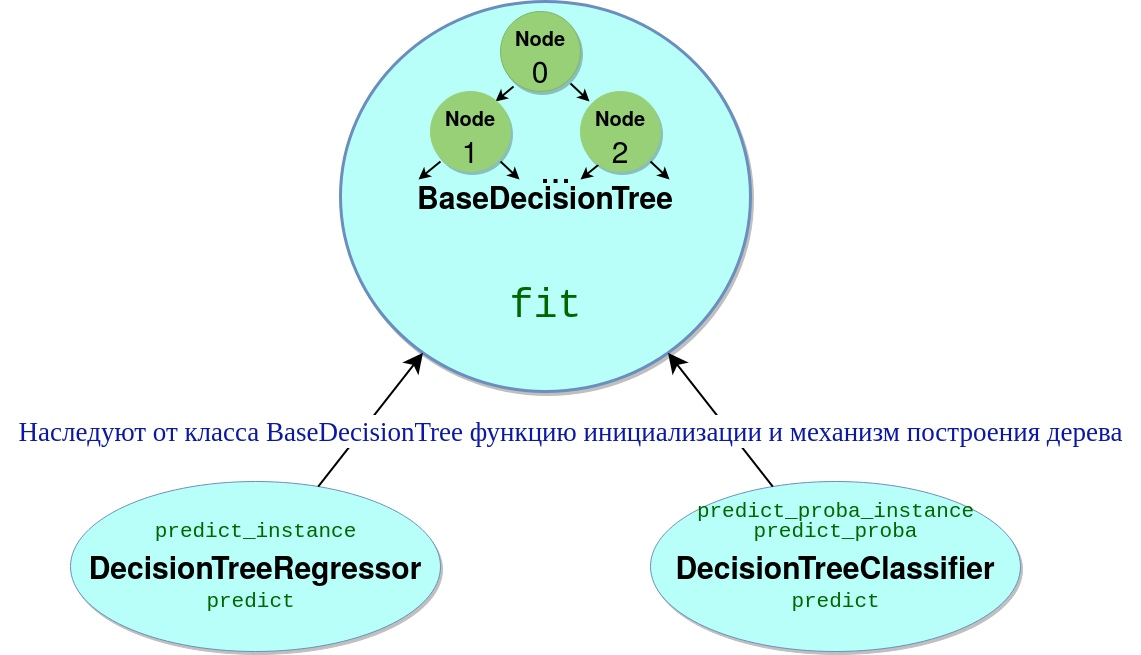

In [29]:
def get_not_nans(arr):
    '''
    Функция, которая создаёт и возвращает новый массив 
    из всех элементов переданного массива, не являющихся None.
    '''
    
    return arr.copy()[~np.isnan(arr)]

In [155]:
from abc import ABC, abstractmethod

class Node(object):
    def __init__(self, split_feature=None, split_threshold=None):
        '''
        Функция инициализации вершины решающего дерева.
        
        Параметры.
        1) split_feature — номер разделяющего признака
        2) split_threshold — пороговое значение
        '''
        
        self.split_feature = split_feature
        self.split_threshold = split_threshold

        # По умолчанию считаем, что у вершины нет дочерних вершин.
        self.left_son, self.right_son = None, None

        # Вероятности попадания в каждую из дочерних вершин нужно поддерживать 
        # для корректной обработки данных с пропусками
        self.left_prob, self.right_prob = 0, 0

        # Массив значений y. Определён только для листовых вершин дерева
        self.y_values = None
        

class BaseDecisionTree(BaseEstimator):
    '''
    Здесь содержится реализация всех основных функций для работы
    с решающим деревом.
    
    Наследование от класса BaseEstimator нужно для того, чтобы 
    в дальнейшем данный   класс можно было использовать в 
    различных функциях библиотеки sklearn, например, в функциях 
    для кросс-валидации.
    '''
    
    def __init__(self, criterion, max_depth=np.inf, min_samples_split=2):
        '''
        Функция инициализации решающего дерева.
        
        Параметры.
        1) criterion — критерий информативности, 
        2) max_depth — максимальная глубина дерева,
        3) min_samples_split — минимальное количество элементов 
        обучающей выборки,  которое должно попасть в вершину, 
        чтобы потом происходило разбиение этой вершины.
        '''
        
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        # Список всех вершин дерева. В самом начале 
        # работы алгоритма есть только одна 
        # вершина — корень.
        self.nodes = [Node()]

        # Количество классов. Актуально только 
        # при решении задачи классификации.
        self.class_count = 1

        # Сюда нужно будет записать все значения 
        # для каждого из признаков датасета
        # (они будут нашими порогами).
        self.feature_values = None
    
    @staticmethod    
    def split(arr, cond):
        return [arr[cond], arr[~cond]]

    def build_(self, v, X, y, depth=0):
        '''
        Рекурсивная функция построения решающего дерева.
        
        Параметры.
        1) v — номер рассматриваемой вершины
        2) X, y — обучающая выборка, попавшая в текущую вершину
        3) depth — глубина вершины с номером v
        '''
        
        if depth == self.max_depth or len(y) < self.min_samples_split:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, 'set_class_count', None)):
                self.nodes[v].y_values = y.copy()

            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        best_criterion_value = np.inf
        best_feature, best_threshold = 0, 0
        sample_size, feature_count = X.shape
        
        # переберём все возможные признаки и значения порогов,
        # найдём оптимальный признак и значение порога 
        # и запишем их в best_feature, best_threshold
        for feature_id in range(feature_count):
            for threshold in self.feature_values[feature_id]:
                # разбиваем на поддеревья
                X_l, X_r = self.split(X, X[:, feature_id] < threshold)
                # пропускаем разбиение на полное и пустое поддеревья, так как это не имеет смысла
                if len(X_l) == 0 or len(X_r) == 0:
                    continue
                # считаем для каждой ветви критерий информативности
                impurity = (len(X_l)/len(X))*self.criterion(X_l) + (len(X_r)/len(X))*self.criterion(X_r)
                # обновляем best_feature и best_threshold, если надо
                if impurity < best_criterion_value:
                    best_criterion_value = impurity
                    best_feature = feature_id
                    best_threshold = threshold
                
        # сохраним найденные параметры в класс текущей вершины
        self.nodes[v].split_feature = best_feature
        self.nodes[v].split_threshold = best_threshold
        # разделим выборку на 2 части по порогу
        question = X[:, best_feature] < best_threshold
        X_l, X_r = self.split(X, question)
        y_l, y_r = self.split(y, question)

        # создаём левую и правую дочерние вершины,
        # и кладём их в массив self.nodes 
        self.nodes.append(Node())
        self.nodes.append(Node())
        
        # сохраняем индексы созданных вершин в качестве 
        # левого и правого сына вершины v
        self.nodes[v].left_son, self.nodes[v].right_son =\
            len(self.nodes)-2, len(self.nodes)-1

        # рекурсивно строим дерево для дочерних вершин
        self.build_(self.nodes[v].left_son, X_l, y_l, depth+1)
        self.build_(self.nodes[v].right_son, X_r, y_r, depth+1)
    
    def fit(self, X, y):
        '''
        Функция, из которой запускается построение 
        решающего дерева по обучающей выборке.
        
        Параметры.
        X, y — обучающая выборка
        '''
        
        # сохраним заранее все пороги для каждого из 
        # признаков обучающей выборки
        X, y = np.array(X), np.array(y)
        self.feature_values = []
        for feature_id in range(X.shape[1]):
            self.feature_values.append(
                np.unique(get_not_nans(X[:, feature_id]))
            )
            
        set_class_count = getattr(self, 'set_class_count', None)

        # если строится дерево для классификации, 
        # то нужно посчитать количество классов 
        if callable(set_class_count):
            set_class_count(y)
        self.build_(0, X, y)
        
        
    @abstractmethod
    def predict(self):
        pass

Теперь, когда общий код решающего дерева написан, нужно сделать обёртки над `BaseDecisionTree` — классы `DecisionTreeRegressor` и `DecisionTreeClassifier` для использования решающего дерева в задачах регрессии и классификации соответственно.

Допишите функции `predict_instance` и `predict_proba_instance` в классах для регрессии и классификации соответственно. В этих функциях нужно для одного элемента $x$ выборки промоделировать спуск в решающем дереве, а затем по листовой вершине, в которой окажется объект, посчитать для классификации — распределение вероятностей, а для регрессии — число $y$.

In [156]:
class DecisionTreeRegressor(BaseDecisionTree):
    def predict_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая значение
        y для одного элемента x из выборки.
        
        Параметры.
        1) x — элемент выборки, для которого
        требуется предсказать значение y
        2) v — рассматриваемая вершина дерева
        '''
        
        # если вершина — лист, возвращаем в качестве предсказания 
        # среднее всех элементов, содержащихся в ней
        if self.nodes[v].left_son is None:
            return np.mean(self.nodes[v].y_values)
            
        # если у объекта x значение признака по
        # которому происходит разделение,  меньше 
        # порогового, то спускаемся в левое поддерево,
        # иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].right_son)
            
        # а если у элемента отсутствует значение 
        # разделяющего признака, то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_instance(x, self.nodes[v].left_son)
            right_predict = self.predict_instance(x, self.nodes[v].right_son)
            return left_predict + right_predict
    
    def predict(self, X):
        '''
        Функция, предсказывающая значение
        y для всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется
        получить вектор предсказаний y
        '''
        
        return [self.predict_instance(x, 0) for x in X]
    
    def predict_iter(self, X):
        return (self.predict_instance(x, 0) for x in X)

Для удобства реализации функции `predict_proba_instance` класса `DecisionTreeClassifier` будем считать, что все классы имеют целочисленные метки от 0 до $k-1$, где $k$ — количество классов. Если бы это условие не было выполнено, то нужно было бы сначала сделать предобработку меток классов в датасете.

In [157]:
class DecisionTreeClassifier(BaseDecisionTree):
    def set_class_count(self, y):
        '''
        Функция, вычисляющая количество классов 
        в обучающей выборке.
        
        Параметры.
        y — значения класса в обучающей выборке
        '''
        
        self.class_count = np.max(y) + 1
    
    def predict_proba_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая вектор
        вероятностей принадлежности  объекта x
        к классам
        
        Параметры.
        1) x — элемент выборки, для которого 
        требуется предсказать значение y
        2) v — вершина дерева, в которой 
        находится алгоритм
        '''
        
        if self.nodes[v].left_son is None:
            # считаем долю каждого класса и возвращаем вектор вероятностей
            y_vals = self.nodes[v].y_values
            vals_cnt_0 = dict(zip(range(self.class_count), np.zeros(self.class_count, dtype=int)))
            vals, counts = np.unique(y_vals, return_counts=True)
            vals_cnt = dict(zip(vals, counts))
            vals_cnt_final = {**vals_cnt_0, **vals_cnt}
            return np.array(list(vals_cnt_final.values())) / len(y_vals)
            
            
        # если у объекта x значение признака по которому
        # происходит разделение, меньше порогового, 
        # то спускаемся в левое поддерево, иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].right_son)
            
        # а если у объекта отсутствует значение 
        # разделяющего признака, то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_proba_instance(
                x, self.nodes[v].left_son)
            right_predict = self.predict_proba_instance(
                x, self.nodes[v].right_son)
            return left_predict + right_predict
    
    def predict_proba(self, X):
        '''
        Функция, предсказывающая вектор вероятностей
        принадлежности объекта x к классам для 
        каждого x из X
        
        Параметры.
        X — выборка, для которой требуется получить вектор предсказаний y
        '''
        return [self.predict_proba_instance(x, 0) for x in X]

        
    def predict(self, X):
        '''
        Функция, предсказывающая метку класса для
        всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется получить
        вектор предсказаний y
        '''
        return np.argmax(self.predict_proba(X), axis=1)
    
    @staticmethod
    def class_predictor_decorator(class_predictor):
        def wrapper(*args):
            return class_predictor(*args, axis=0)
        return wrapper
                
    @staticmethod
    def predict_class_mapper(class_predictor, elements):
        predictor = DecisionTreeClassifier.class_predictor_decorator(class_predictor)
        for elem in elements:
            yield predictor(elem)

**Подбор параметров.**

В этой части задания вам предлагается поработать с написанным решающим деревом, применив его к задачи классификации и регрессии, и в обеих задачах подобрать оптимальные параметры для построения.

Не забывайте писать выводы.

**1. Задача классификации.**

Теперь самое время протестировать работу написанного нами решающего дерева. Делать мы это будем на датасете для классификации вина из `sklearn`.

In [182]:
X, y = load_wine(return_X_y=True)

ValueError: not enough values to unpack (expected 3, got 2)

In [185]:
load_wine()['feature_names']

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

Далее для критерия Джини и энтропийного критерия найдем оптимальные параметры обучения дерева — `max_depth` и `min_samples_split`.

In [34]:
classification_criteria = [gini_criterion, entropy_criterion]
criterion_names = ['gini', 'entropy']

С начала надо разбить выборку на train и test.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

Пример использования DecisionTreeRegressor

In [158]:
test_model = DecisionTreeRegressor(criterion=gini_criterion, max_depth=5, min_samples_split=2)
test_model.fit(X_train, y_train)


predictions_iter = test_model.predict_iter(X_test)

In [159]:
next(predictions_iter)

0.10344827586206896

In [189]:
test_model = DecisionTreeClassifier(criterion=gini_criterion, max_depth=5, min_samples_split=2)
test_model.fit(X_train, y_train)
proba_predictions = test_model.predict_proba(X_test)

class_predictions_iter = DecisionTreeClassifier.predict_class_mapper(np.argmax, proba_predictions)

In [190]:
test_model.predict(X_test)

array([0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 2, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [195]:
next(class_predictions_iter)

1

In [176]:
next(class_predictions_iter)

1

Теперь проведите кросс-валидацию для каждого из критериев разбиения вершин.

In [464]:
parameters_grid = {
    'max_depth' : range(1, 11),
    'min_samples_split': range(2, 11)
}

In [398]:
for criterion, criterion_name in zip(classification_criteria, criterion_names):
    gs = GridSearchCV(
        estimator=DecisionTreeClassifier(criterion=criterion),
        param_grid=parameters_grid,
        n_jobs=-1,
        scoring='accuracy'
    )
    gs.fit(X_train, y_train)
    print(gs.best_estimator_)
    
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = gs.best_params_['max_depth']
    min_samples_split = gs.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {min_samples_split}')
    
    # Выведем качество на тесте
    accuracy = accuracy_score(y_test, gs.best_estimator_.predict(X_test))
    print(f'Accuracy на тесте: {accuracy:.3f}')
    assert(accuracy >= 0.85, 'Качество получилось ниже ожидаемого, поищите ошибку')

DecisionTreeClassifier(criterion=<function gini_criterion at 0x7fcbd080d280>,
                       max_depth=8, min_samples_split=3)
Оптимальный max_depth: 8
Оптимальный min_samples_split: 3
Accuracy на тесте: 0.806
DecisionTreeClassifier(criterion=<function entropy_criterion at 0x7fcbd080d310>,
                       max_depth=7)
Оптимальный max_depth: 7
Оптимальный min_samples_split: 2
Accuracy на тесте: 0.861


**Построение графиков.**

Постройте графики зависимости accuracy от максимальной глубины дерева на обучающей и тестовой выборке для каждого критерия на train и на test. В качестве максимальной глубины используйте значения от 1 до 14. Значение `min_samples_split` фиксируйте.

In [465]:
def get_accuracies(max_depth_grid, criterion, model_name, score):
    accuracies_dict = {'train': [], 'test': []}
    for max_depth in max_depth_grid:
        if model_name == 'DecisionTreeClassifier':
            model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=2)
        elif model_name == 'DecisionTreeRegressor':
            model = DecisionTreeRegressor(criterion=criterion, max_depth=max_depth, min_samples_split=2)
        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        accuracy_train = score(y_pred_train, y_train)
        
        y_pred_test = model.predict(X_test)
        accuracy_test = score(y_pred_test, y_test)
        
        accuracies_dict['train'].append(accuracy_train)
        accuracies_dict['test'].append(accuracy_test)
    return accuracies_dict

In [466]:
max_depth_grid = range(1, 15)


gini_accuracies = get_accuracies(max_depth_grid, gini_criterion, 'DecisionTreeClassifier', accuracy_score)
entropy_accuracies = get_accuracies(max_depth_grid, entropy_criterion, 'DecisionTreeClassifier', accuracy_score)

In [454]:
# код построения графиков

def plot_dependence(param_name, grid, metric, accuracies, title=''):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика
    4) accuracies - словарь со значениями признака на тесте и трейне
    '''
    
    plt.figure(figsize=(12, 6))

    train_acc, test_acc = accuracies['train'], accuracies['test']

    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel(metric)
    plt.title(title, fontsize=20)
    plt.show()
    sns.set_style('whitegrid')

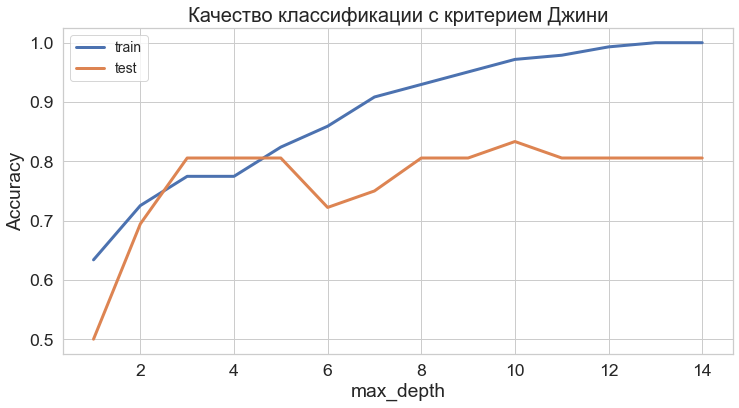

In [467]:
plot_dependence('max_depth', max_depth_grid, 'Accuracy', gini_accuracies, 'Качество классификации с критерием Джини')

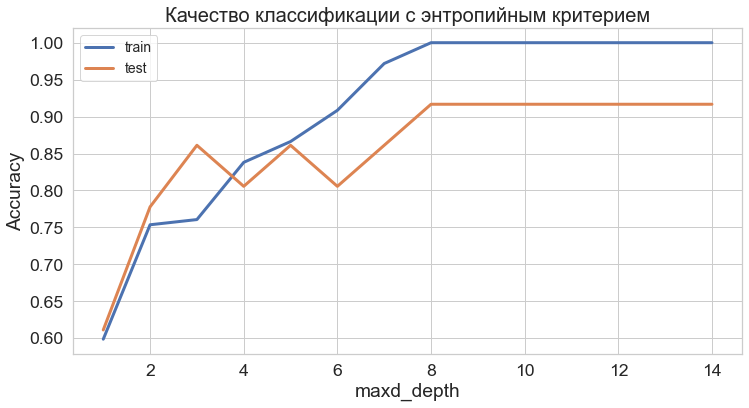

In [469]:
plot_dependence('maxd_depth', max_depth_grid, 'Accuracy', entropy_accuracies, 'Качество классификации с энтропийным критерием')

Сделайте выводы. Почему графики получились такими? Как соотносятся оптимальные значения параметров на обучающей и на тестовой выборках?

**Вывод.**
*В обоих случаях классификаций после определенных значений `max_depth` значение `accuracy` выходило на плато, то есть после определенной глубины дерева повышать ее смысла не имеет, так как точность предсказания достигла предельного значения. В случае энтропийного критерия зависимости для тестовой и тренировочной выборок очень похожи и выходят на плато при одном и том же значении `max_depth = 8`, в случае критерий Джини зависимости разные, на тренировочной выборке accuracy растет намного быстрее. Также точность в случае критерия Джини растет быстрее, так как энтропийный критерий более вычислительго сложный.*

*Ожидаемо, предельные значения accuracy на тестовой выборке были 1 (чем больше листьев, тем больше переобучено дерево), на тестовой - намного ниже.*

**2. Задача регрессии.**

Проделайте аналогичные шаги для задачи регрессии. В качестве датасете возьмите `boston` из `sklearn`, а в качестве критерия качества возьмите `r2_score`. Рассмотрим диапозон значений для `max_depth`: от 3 до 14.

In [407]:
boston_X, boston_y = load_boston(return_X_y=True)

In [408]:
regression_criteria = [mean_square_criterion, mean_abs_criterion]
criterion_names = ['MSE', 'MAE']

Разобьём выборку на обучение и тест.

In [411]:
X_train, X_test, y_train, y_test = train_test_split(boston_X, boston_y, random_state=43, train_size=0.8)

Проведите эксперименты, аналогичны тем, что были сделаны для задачи классификации.

In [434]:
parameters_grid = {
    'max_depth' : range(3, 14),
    'min_samples_split': range(2, 6)
}

In [435]:
for criterion, criterion_name in zip(regression_criteria, criterion_names):
    gs = GridSearchCV(
        estimator=DecisionTreeRegressor(criterion=criterion),
        param_grid=parameters_grid,
        n_jobs=-1,
        scoring='r2'
    )
    gs.fit(X_train, y_train)
    print(gs.best_estimator_)
    
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = gs.best_params_['max_depth']
    min_samples_split = gs.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {min_samples_split}')
    
    # Выведем качество на тесте
    r2 = r2_score(y_test, gs.best_estimator_.predict(X_test))
    print(f'R2 score на тесте: {r2:.3f}')

DecisionTreeRegressor(criterion=<function mean_square_criterion at 0x7fcbf16c2a60>,
                      max_depth=11, min_samples_split=4)
Оптимальный max_depth: 11
Оптимальный min_samples_split: 4
R2 score на тесте: 0.469
DecisionTreeRegressor(criterion=<function mean_abs_criterion at 0x7fcbf1525280>,
                      max_depth=8, min_samples_split=5)
Оптимальный max_depth: 8
Оптимальный min_samples_split: 5
R2 score на тесте: 0.731


In [445]:
max_depth_grid = range(3, 15)

mse_accuracies = get_accuracies(max_depth_grid, mean_square_criterion, 'DecisionTreeRegressor', r2_score)
mae_accuracies = get_accuracies(max_depth_grid, mean_abs_criterion, 'DecisionTreeRegressor', r2_score)

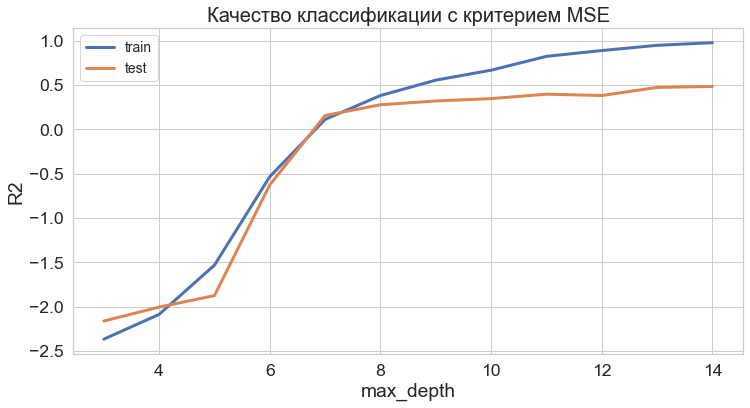

In [452]:
plot_dependence('max_depth', max_depth_grid, 'R2', mse_accuracies, 'Качество классификации с критерием MSE')

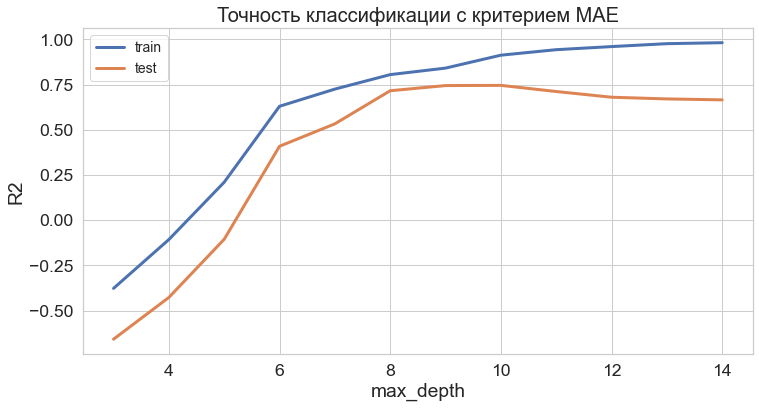

In [451]:
plot_dependence('max_depth', max_depth_grid, 'R2', mae_accuracies, 'Точность классификации с критерием MAE')

*В случае регрессии обучение по обоим критериям примерно одинаковой скрости, в случае MSE train и test обучаются более похоже по скорости, чем в случае MAE. Аналогично ождаемо R2 на train достигает наилучшего значения 1 из-за переобучения под тренировочную выборку.*

Сделайте вывод, в котором объясните, почему графики получились такими.

Скорее всего, вы заметили, что дерево в этих экспериментах строится довольно медленно. Как можно ускорить его построение? Можно ли ускорить нахождение оптимального разбиения по некоторому вещественному признаку?

**Вывод.**

*Алгоритм медленный из-за рекурсии и вложенных циклов. Чем больше будет фичей, max_depth и min_samples_split, тем дольше будут строиться деревья за счет долгого подбора оптимального разбиения. Одно из простых улучшений: не смотреть значение как порог, если у соседних значений те же классы, такой сплит не будет эффективным. Кандидатами на пороги можно брать среднее между двумя соседними значениями признака, у которых разные классы.*

## Задача 5

В этой задаче вам предстоит освоиться с обработкой пропусков в решающих деревьях, реализованной ранее.

Рассмотрим датасет, в котором часть данных пропущена. В качестве примера возьмём датасет https://archive.ics.uci.edu/ml/datasets/Adult для определения категории дохода работников, по таким признакам, как возраст, образование, специальность, класс работы, пол, кол-во отрабатываемых часов в неделю и некоторым другим.

In [470]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education1', 'education2', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'target'
]

Поскольку предсказание в дереве на данных с пропусками часто занимает сильно больше времени, чем в случае отсутствия пропусков (так как часто приходится спускаться разу в 2 поддерева), то для экономии времени сократим датасет, взяв из него только первые 10000 строк данных.

In [471]:
adult_df = pd.read_csv('adult.data', header=None)[:10000]
adult_df.columns = column_names
target = adult_df['target'] == ' >50K'
adult_df = adult_df.drop(['target'], axis=1)
adult_df.head()

,age,workclass,fnlwgt,education1,education2,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


Предобработаем датасет, заменив категориальные признаки one-hot векторами.

In [472]:
adult_df = pd.get_dummies(adult_df)
adult_df.head()

,age,fnlwgt,education2,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Поскольку все пропущенные значения относились к категориальным признакам и помечались в датасете знаком `?`, то для каждого категориального признака `feature` исходного датасета надо выполнить следующую процедуру: рассмотреть признак `feature_?` нового датасета и для всех строк, для которых выполнено `feature_?=1`, значениях всех признаков с префиксом `feature` установить в `None`. 

In [473]:
all_indices = np.arange(adult_df.shape[0])

for feature in column_names:
    if f'{feature}_ ?' in adult_df.columns:
        none_indices = all_indices[adult_df[f'{feature}_ ?'] == 1]
        
        for dummy_feature in adult_df.columns:
            if not dummy_feature.startswith(f'{feature}_ '):
                continue
            if dummy_feature != f'{feature}_ ?':
                adult_df[dummy_feature][none_indices] = None
        adult_df = adult_df.drop(f'{feature}_ ?', axis=1)

Посмотрим на распределение пропущенных значений по признакам.

In [474]:
np.sum(adult_df.isnull(), axis=0)

age                                  0
fnlwgt                               0
education2                           0
capital-gain                         0
capital-loss                         0
                                  ... 
native-country_ Thailand           181
native-country_ Trinadad&Tobago    181
native-country_ United-States      181
native-country_ Vietnam            181
native-country_ Yugoslavia         181
Length: 104, dtype: int64

Разобьём данные на обучающую и тестовую выборки в отношении 3:1.

In [475]:
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    adult_df, target, random_state=777
)

При помощи кросс-валидации найдём оптимальные гиперпараметры для каждого из критериев разбиения деревьев для классификации.

In [476]:
parameters_grid = {
    'max_depth' : range(1, 11),
    'min_samples_split': range(2, 11)
}

In [ ]:
for criterion, criterion_name in zip(classification_criteria, criterion_names):
    gs = GridSearchCV(
        estimator=DecisionTreeClassifier(criterion=criterion),
        param_grid=parameters_grid,
        n_jobs=-1,
        scoring='accuracy'
    )
    gs.fit(X_adult_train, y_adult_train)
    print(gs.best_estimator_)
    
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = gs.best_params_['max_depth']
    min_samples_split = gs.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {min_samples_split}')
    
    # Выведем качество на тесте
    accuracy = accuracy_score(y_adult_test, gs.best_estimator_.predict(X_adult_test))
    print(f'Accuracy на тесте: {accuracy:.3f}')

Проведите эксперименты c построением графиков, аналогичные тем, что были сделаны в предыдущем пункте для задач классификации и регрессии.

In [ ]:
def get_accuracies(max_depth_grid, criterion, score):
    accuracies_dict = {'train': [], 'test': []}
    for max_depth in max_depth_grid:
        model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=2)
        model.fit(X_adult_train, y_adult_train)
        
        y_pred_train = model.predict(X_adult_train)
        accuracy_train = score(y_pred_train, y_adult_train)
        
        y_pred_test = model.predict(X_adult_test)
        accuracy_test = score(y_pred_test, y_adult_test)
        
        accuracies_dict['train'].append(accuracy_train)
        accuracies_dict['test'].append(accuracy_test)
    return accuracies_dict

In [ ]:
max_depth_grid = range(1, 15)


gini_accuracies = get_accuracies(max_depth_grid, gini_criterion, accuracy_score)
entropy_accuracies = get_accuracies(max_depth_grid, entropy_criterion, accuracy_score)

In [ ]:
plot_dependence('max_depth', max_depth_grid, 'Accuracy', gini_accuracies, 'Качество классификации с критерием Джини')

In [ ]:
plot_dependence('maxd_depth', max_depth_grid, 'Accuracy', entropy_accuracies, 'Качество классификации с энтропийным критерием')

**Вывод.**

<...>